# Deep learning for Natural Language Processing


 * Simple text representations, bag of words
 * Word embedding and... not just another word2vec this time
 * rnn for text
 * Aggregating several data sources "the hard way"
 * Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning
 

Special thanks to Irina Golzmann for help with technical part, task prepared by Александр Панин, jheuristic@yandex-team.ru

# NLTK

You will require nltk v3.2 to solve this assignment

__It is really important that the version is 3.2, otherwize russian tokenizer might not work__

Install/update
* `sudo pip install --upgrade nltk==3.2`
* If you don't remember when was the last pip upgrade, `sudo pip install --upgrade pip`

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

# For students with low-RAM machines
 * This assignment can be accomplished with even the low-tier hardware (<= 4Gb RAM) 
 * If that is the case, turn flag "low_RAM_mode" below to True
 * If you have around 8GB memory, it is unlikely that you will feel constrained by memory.
 * In case you are using a PC from last millenia, consider setting very_low_RAM=True

In [1]:
low_RAM_mode = True
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [3]:
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
 

In [4]:
print(df.shape, df.is_blocked.mean())
df[:5]

(1204949, 13) 0.22822210732570425


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49
3,10000309,Недвижимость,Квартиры,"1-к квартира, 44 м², 9/20 эт.","В кирпичном пан.-м доме, продается одноком.-ая...","{""Тип объявления"":""Продам"", ""Количество комнат...",2642020,NaN,0,1,0,0,22.47
4,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0.0,1,0,0,0,1.43


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [5]:
print("Blocked ratio",df.is_blocked.mean())
print("Count:",len(df))

Blocked ratio 0.22822210732570425
Count: 1204949


# Balance-out the classes
* Vast majority of data samples are non-prohibited
 * 250k banned out of 4kk
 * Let's just downsample random 250k legal samples to make further steps less computationally demanding
 * If you aim for high Kaggle score, consider a smarter approach to that.


In [6]:
#downsample

not_blocked = df[df.is_blocked == 0]
blocked = df[df.is_blocked == 1]
df = not_blocked.sample(len(blocked), random_state=42).append(blocked)


print("Blocked ratio:",df.is_blocked.mean())
print("Count:",len(df))

Blocked ratio: 0.5
Count: 549992


In [7]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print("All tests passed")

All tests passed


In [8]:
# #In case your RAM-o-meter is in the red
# if very_low_ram:
#     data = data[::2]

# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [9]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

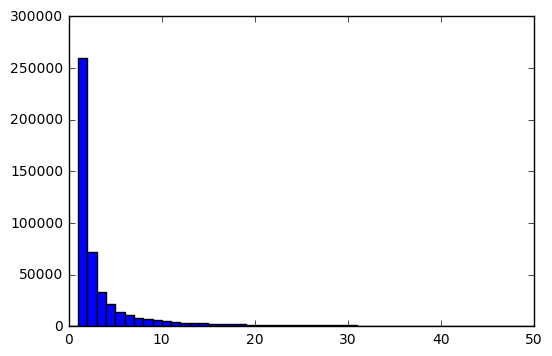

In [10]:
#Word frequency distribution, just for kicks
_ = plt.hist(list(token_counts.values()), range=[0,50], bins=50)

In [11]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 50
tokens = [token for token, count in token_counts.items() if count >= min_count]


In [12]:
token_to_id = {t:i+2 for i,t in enumerate(tokens)}
null_token = "NULL"
unk_token = "UNK"
token_to_id[null_token] = 0
token_to_id[unk_token] = 1

In [13]:
print("# Tokens:",len(token_to_id))
if len(token_to_id) < 30000:
    print("Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc")
if len(token_to_id) > 1000000:
    print("Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc")

# Tokens: 32162


### Replace words with IDs
Set a maximum length for titles and descriptions.
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [14]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.lower()
        tokens = tokenizer.tokenize(s)
        token_ids = list(map(lambda token: token_to_id.get(token,1), tokens))[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [15]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Data format examples


In [16]:
print("Размер матрицы:",title_tokens.shape)
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print(title,'->', tokens[:10],'...')

Размер матрицы: (549992, 15)
Вещи для девочки -> [  587 18926  5456     0     0     0     0     0     0     0] ...
Nissan Juke, 2011 -> [ 1953 32110  2652     0     0     0     0     0     0     0] ...
Кладка пеноблоков, фундаменты, срубы -> [ 1400 10612 20232  3459     0     0     0     0     0     0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing.

In [17]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]


In [18]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df[["category","subcategory"]].values

# categories = [A list of dictionaries {"category":category_name, "subcategory":subcategory_name} for each data sample]
categories = [{"category":d_c_s[0], "subcategory":d_c_s[1]} for d_c_s in data_cat_subcat]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [19]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Split data into training and test

In [20]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
#Split into training and test set.


#Difficulty selector:
#Easy: split randomly
#Medium: select test set items that have item_ids strictly above that of training set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard

title_tr, title_ts, desc_tr, desc_ts, nontext_tr, nontext_ts, target_tr, target_ts = train_test_split(
    title_tokens, desc_tokens, df_non_text, target, test_size=0.2, random_state=42)

## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [1]:
save_prepared_data = False #save
read_prepared_data = True #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    print("Saving preprocessed data (may take up to 3 minutes)")
    data_tuple = title_tr, title_ts, desc_tr, desc_ts, nontext_tr, nontext_ts, target_tr, target_ts
    import pickle
    with open("preprocessed_data.pcl",'wb') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'wb') as fout:
        pickle.dump(token_to_id,fout)

    print("готово")
    
elif read_prepared_data:
    print("Reading saved data...")
    
    import pickle
    
    with open("preprocessed_data.pcl",'rb') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'rb') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print("done")

Reading saved data...
done


In [2]:
nontext_tr.shape

(439993, 67)

In [3]:
len(token_to_id)

32162

# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles: RNN
* Separate input for description: RNN
* Separate input for categorical features: обычные полносвязные слои или какие-нибудь трюки
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal with binary_crossentropy
 * 2 softmax with categorical_crossentropy - essentially the same as previous one
 * 1 neuron without nonlinearity (lambda x: x) +  hinge loss
 

# NN architecture

In [4]:
import keras.layers as layer
import keras.losses as lossses
import keras.optimizers as optimizers
import keras.metrics as metrics
import keras.callbacks as callbacks
import keras.models as models

Using TensorFlow backend.


In [5]:
title_token_ids = layer.Input(
    shape=(15, ), dtype="int32", name="title_token_ids")
desc_token_ids = layer.Input(
    shape=(150, ), dtype="int32", name="desc_token_ids")
categories = layer.Input(
    shape=(67, ), dtype="float32", name="categories")

In [6]:
emb_matr = layer.Embedding(input_dim=32162, output_dim=300, mask_zero=True)

title_embed = emb_matr(title_token_ids)

desc_embed = emb_matr(desc_token_ids)

categories_embed = layer.Dense(32, activation="elu")(categories)

In [7]:
lstm = layer.LSTM(300)

title_rerp = lstm(title_embed)
desc_rerp = lstm(desc_embed)

In [8]:
concat_repr = layer.Concatenate()([title_rerp, desc_rerp, categories_embed])
concat_repr = layer.Dropout(0.5)(concat_repr)
logits = layer.Dense(128, activation="elu")(concat_repr)
y_pred = layer.Dense(1, activation="sigmoid")(logits)

In [9]:
model = models.Model(
    inputs=[title_token_ids, desc_token_ids, categories], outputs=y_pred, name="targetator")

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
 * Function description may mention some +-1  limitations - this is not neccessary, at least as long as hinge loss has a __default__ flag `binary = True`

In [10]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])

In [11]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
title_token_ids (InputLayer)     (None, 15)            0                                            
____________________________________________________________________________________________________
desc_token_ids (InputLayer)      (None, 150)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          multiple              9648600     title_token_ids[0][0]            
                                                                   desc_token_ids[0][0]             
____________________________________________________________________________________________________
categories (InputLayer)          (None, 67)            0                                   

# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [12]:
#average precision at K

# from oracle import APatK, score

In [13]:
# # Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

# def iterate_minibatches(*arrays,**kwargs):
#     batchsize=kwargs.get("batchsize",100)
#     shuffle = kwargs.get("shuffle",True)
    
#     if shuffle:
#         indices = np.arange(len(arrays[0]))
#         np.random.shuffle(indices)
#     for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
#         if shuffle:
#             excerpt = indices[start_idx:start_idx + batchsize]
#         else:
#             excerpt = slice(start_idx, start_idx + batchsize)
#         yield [arr[excerpt] for arr in arrays]

### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs

* AUC is the most stable of all three metrics

* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [16]:
nontext_tr = nontext_tr.values
nontext_ts = nontext_ts.values
target_tr = np.expand_dims(target_tr, -1)
target_ts = np.expand_dims(target_ts, -1)

In [17]:
# forget about callbacks :(
history = model.fit(
    x=[title_tr, desc_tr, nontext_tr], y=target_tr, epochs=10, batch_size=1000,
    validation_data=([title_ts, desc_ts, nontext_ts], target_ts))

Train on 439993 samples, validate on 109999 samples
Epoch 1/40
439993/439993 [==============================] - 811s - loss: 2.3338 - binary_accuracy: 0.8279 - val_loss: 1.3050 - val_binary_accuracy: 0.9072
Epoch 2/40
439993/439993 [==============================] - 812s - loss: 1.6867 - binary_accuracy: 0.8807 - val_loss: 1.1523 - val_binary_accuracy: 0.9063
Epoch 3/40
439993/439993 [==============================] - 812s - loss: 1.3637 - binary_accuracy: 0.9009 - val_loss: 1.0408 - val_binary_accuracy: 0.9197
Epoch 4/40
439993/439993 [==============================] - 813s - loss: 1.1585 - binary_accuracy: 0.9110 - val_loss: 0.9461 - val_binary_accuracy: 0.9250
Epoch 5/40
439993/439993 [==============================] - 811s - loss: 0.7580 - binary_accuracy: 0.9324 - val_loss: 0.3606 - val_binary_accuracy: 0.9401
Epoch 6/40
439993/439993 [==============================] - 812s - loss: 0.2020 - binary_accuracy: 0.9548 - val_loss: 0.1454 - val_binary_accuracy: 0.9575
Epoch 7/40
439993/

In [19]:
from rstools.visualization.plotter import plot_all_metrics

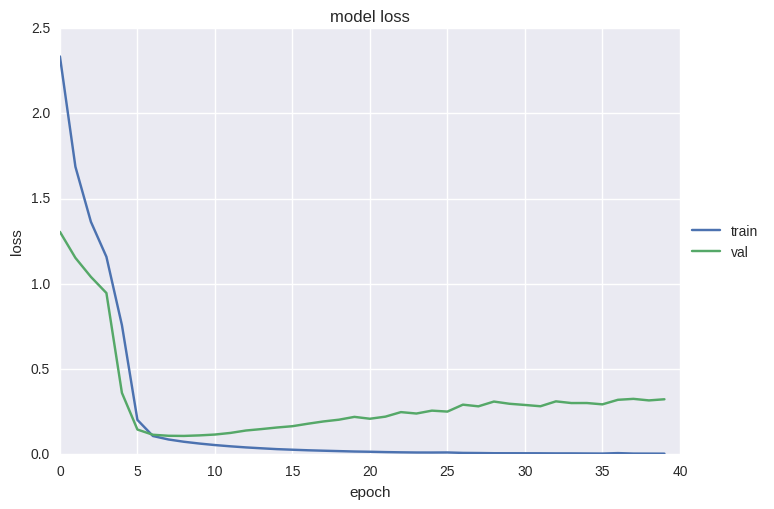

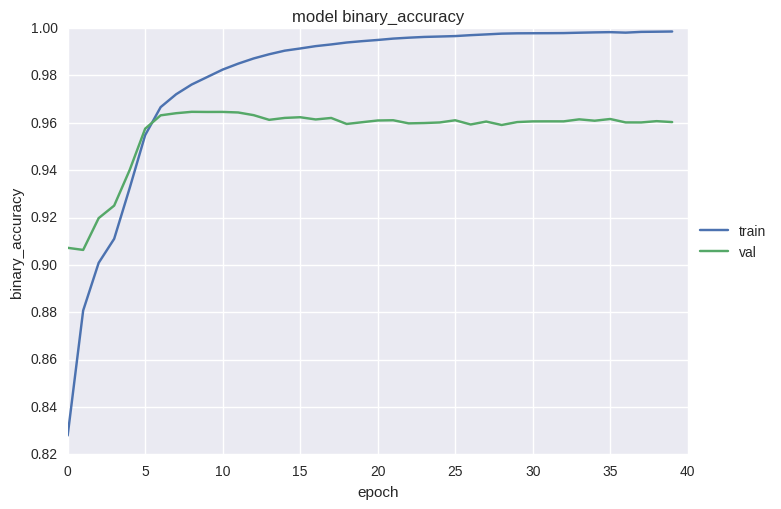

In [20]:
plot_all_metrics(history=history.history, show=True)

# Final evaluation
Evaluate network over the entire test set

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [22]:
y_pred_score = model.predict(x=[title_ts, desc_ts, nontext_ts], batch_size=1000)

In [24]:
roc_auc_score(target_ts.ravel(), y_pred_score.ravel())

0.98966009580339476

In [29]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(target_ts.ravel(), y_pred_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

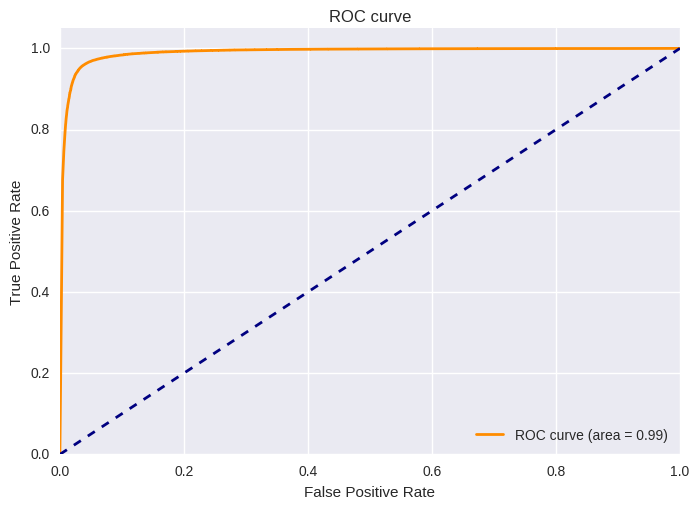

In [30]:
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Main task

* https://goo.gl/forms/eJwIeAbjxzVuo6vn1
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther

* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92

* Remember the training, Luke
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
 * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.